In [1]:
import os
from osgeo import gdal,ogr,osr,gdalnumeric
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import rasterio
import fiona
import rasterio.mask

Ref: https://stackoverflow.com/questions/69938501/clipping-raster-through-a-shapefile-using-python

In [42]:
us_counties = gp.read_file(r'\Users\mhardika\Downloads\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:3857")

Function to go through county lists in Arizona

In [43]:
az_counties = us_counties.loc[us_counties['STATEFP']=='04']

In [40]:
def create_az_images(county,geometry):
    src_raster_path = '/Users/mhardika/Downloads/az_cultivated/clipped.TIF'
    output_raster_path = '/Users/mhardika/Downloads/az_cultivated/folder/'+ county +'.tif'

    with rasterio.open(src_raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [geometry], crop=True)
        out_meta = src.meta


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})


    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)


def convert_to_shape(county):
    ds = gdal.Open('/Users/mhardika/Downloads/az_cultivated/folder/'+county+'.tif')
    ds.RasterCount
    srcband = ds.GetRasterBand(1)
    proj = ds.GetProjection()
    
    shp_proj = osr.SpatialReference()
    shp_proj.ImportFromWkt(proj)
    call_drive = ogr.GetDriverByName('ESRI Shapefile')
    create_shp = call_drive.CreateDataSource('/Users/mhardika/Downloads/az_cultivated/folder/'+county+'_output_shapefile.shp')

    shp_layer = create_shp.CreateLayer('layername',srs=shp_proj)
    new_field = ogr.FieldDefn(str('ID'),ogr.OFTInteger)
    shp_layer.CreateField(new_field)

    gdal.Polygonize(srcband,None,shp_layer,0,[],callback = None)
    create_shp.Destroy()
    ds = None


In [44]:
az_counties.geometry[0:1]

398    POLYGON ((-12775469.819 3848061.612, -12775393...
Name: geometry, dtype: geometry

In [45]:
for index,row in az_counties.iterrows():
    # print(row['NAME'])
    # print(row['geometry'])
    create_az_images(row['NAME'],row['geometry'])


Yuma
POLYGON ((-12775469.81876026 3848061.612303413, -12775393.2309506 3848227.12967946, -12775415.71748774 3848409.439438901, -12775500.09766176 3848560.683316141, -12775572.1213723 3848684.958579367, -12775580.13637564 3848782.793216205, -12775575.7949155 3848858.417301067, -12775500.54293972 3848947.395209145, -12775186.3993367 3849294.190683791, -12774836.63349663 3849623.543422303, -12774606.31347018 3849796.883695866, -12774257.883464 3850036.866988948, -12774031.6822587 3850233.220580339, -12773999.39960637 3850286.243220612, -12773989.60349119 3850295.763520365, -12773853.68239292 3850496.484958781, -12773688.92954656 3850814.366991184, -12773685.58996183 3850837.375423541, -12773682.13905761 3850867.788937353, -12773685.58996183 3850886.962714554, -12773694.05024313 3850908.120022045, -12773709.30101337 3850935.227877626, -12773694.05024313 3851049.346019852, -12773683.92016947 3851142.175263559, -12773673.67877631 3851207.632219958, -12773673.67877631 3851248.096701635, -1277

In [46]:
for index,row in az_counties.iterrows():
    convert_to_shape(row['NAME'])

In [16]:
# ds = gdal.Open('/Users/mhardika/Downloads/az_cultivated/folder/county_masked.tif')
ds = gdal.Open('/Users/mhardika/Downloads/az_cultivated/folder/county_masked_some.tif')
ds.RasterCount
srcband = ds.GetRasterBand(1)
srcband.ReadAsArray()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [17]:
proj = ds.GetProjection()
shp_proj = osr.SpatialReference()
shp_proj.ImportFromWkt(proj)
call_drive = ogr.GetDriverByName('ESRI Shapefile')
# create_shp = call_drive.CreateDataSource('/Users/mhardika/Downloads/az_cultivated/folder/az_cultivated_output_shapefile.shp')
create_shp = call_drive.CreateDataSource('/Users/mhardika/Downloads/az_cultivated/folder/az_cultivated_some_output_shapefile.shp')

# shp_layer = create_shp.CreateLayer('layername',srs=shp_proj)
shp_layer = create_shp.CreateLayer('layername_some',srs=shp_proj)
new_field = ogr.FieldDefn(str('ID'),ogr.OFTInteger)
shp_layer.CreateField(new_field)

gdal.Polygonize(srcband,None,shp_layer,0,[],callback = None)
create_shp.Destroy()
ds = None

<AxesSubplot: >

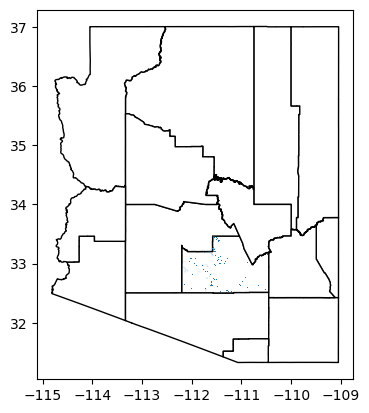

In [19]:
sample = gp.read_file('/Users/mhardika/Downloads/az_cultivated/folder/az_cultivated_some_output_shapefile.shp')
sample = sample.loc[sample['ID']==121]
sample = sample.to_crs("EPSG:4326")
fig, ax = plt.subplots()

az_counties = az_counties.to_crs("EPSG:4326")
az_counties.plot(ax=ax,color = 'white',edgecolor ='black')
sample.plot(ax=ax,figsize=(50, 50))

In [10]:
sample.loc[sample['ID']==121]

,ID,geometry
0,121,"POLYGON ((-111.58076 33.46591, -111.58049 33.4..."
2,121,"POLYGON ((-111.56513 33.46591, -111.56270 33.4..."
3,121,"POLYGON ((-111.56028 33.46591, -111.56001 33.4..."
4,121,"POLYGON ((-111.55839 33.46591, -111.55812 33.4..."
6,121,"POLYGON ((-111.55058 33.46591, -111.54869 33.4..."
...,...,...
455462,121,"POLYGON ((-111.23500 32.50157, -111.23311 32.5..."
455464,121,"POLYGON ((-111.23230 32.50157, -111.23123 32.5..."
455465,121,"POLYGON ((-111.23096 32.50157, -111.22934 32.5..."
455466,121,"POLYGON ((-111.24901 32.50157, -111.24874 32.5..."
